In [75]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import img_as_ubyte
from skimage.util import img_as_float

from skimage.morphology import disk 
from skimage.morphology import erosion, dilation

*PREPROCESSING*

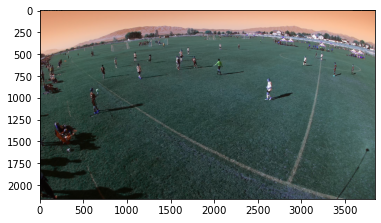

In [76]:
# im_org = cv2.imread("video_1_00_46_13_left001.png")
# im_org = cv2.imread("video_4_00_26_20_left001.png")
# im_org = cv2.imread("video_1_00_26_20_left001.png")
# im_org = cv2.imread("video_7_00_46_13_left001.png")


#Image that we are going to use
im_org = cv2.imread("video_4_00_45_25_left001.png")




plt.imshow(im_org)

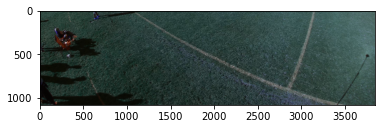

In [77]:
#take only down-right corner
cropped_im = im_org[int(im_org.shape[0]/2):,:]
plt.imshow(cropped_im)

In [78]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.0
    max_desired = 1.0
    img_out = (img_float-min_val)*(1/(max_val-min_val))
    return img_as_ubyte(img_out)


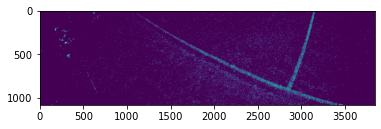

In [79]:
#extract rgb
r_comp = cropped_im[:, :, 0]
g_comp = cropped_im[:, :, 1]
b_comp = cropped_im[:, :, 2] 

thres = 120

# take only the white parts
white_im = (r_comp > thres) & (g_comp > thres) & (b_comp  > thres)

white_im = histogram_stretch(white_im)

# white_im = img_as_ubyte(white_im)

plt.imshow(white_im)

In [80]:
def find_contours(thresh, img):
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # Use cv2.CCOMP for two level hierarchy
    output = img.copy()
    for c in contours:
        if cv2.arcLength(c, True) < 1000:
                continue
        
        cv2.drawContours(output, [c], 0, (255), thickness=20)
    return output

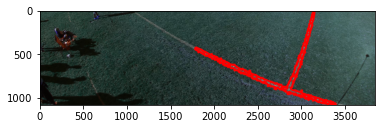

In [81]:
footprint_e = disk(1.5)
footprint_d = disk(4)
ero_im = erosion(white_im, footprint_e)
dil_im = dilation(ero_im, footprint_d)
outline = np.logical_xor(dil_im, white_im)
outline = img_as_ubyte(outline)

contours = find_contours(outline, cropped_im)


plt.imshow(contours)

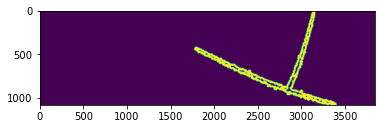

In [82]:
#extract rgb
r_comp = contours[:, :, 0]
g_comp = contours[:, :, 1]
b_comp = contours[:, :, 2] 

# thres = 120

# take only the red parts
red_im = (r_comp > 250) & (g_comp < 5) & (b_comp  < 5)
red_im = img_as_ubyte(red_im)
plt.imshow(red_im)


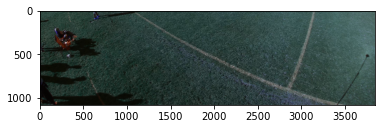

In [83]:
test = cropped_im.copy()
plt.imshow(test)

In [84]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return int(x), int(y)


In [85]:
def is_parallel_line(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return True
    else: 
        return False

This is the threshold: 200
Number of lines: 9
This is the threshold: 300
Number of lines: 6
This is the threshold: 400
Number of lines: 6
This is the threshold: 500
Number of lines: 7
This is the threshold: 600
Number of lines: 7
This is the threshold: 700
Number of lines: 8
This is the threshold: 800
Number of lines: 11
This is the threshold: 900
Number of lines: 8
This is the threshold: 1000
Number of lines: 8
This is the threshold: 1100
Number of lines: 10
This is the threshold: 1200
Number of lines: 11
This is the threshold: 1300
Number of lines: 7
This is the threshold: 1400
Number of lines: 9
This is the threshold: 1500
Number of lines: 12
This is the threshold: 1600
Number of lines: 9
This is the threshold: 1700
Number of lines: 5
This is the threshold: 1800
Number of lines: 9
This is the threshold: 1900
Number of lines: 19
This is the threshold: 2000
Number of lines: 9
This is the threshold: 2100
Number of lines: 16
This is the threshold: 2200
Number of lines: 10
This is the th

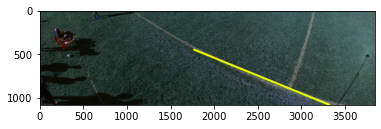

In [95]:
thres = 10**2
l_lines = 4
lim = 2
iterations = 0
while(l_lines > lim ):
  iterations += 1
  lines = cv2.HoughLinesP(
              red_im, # Input edge image
              10, # Distance resolution in pixels
              np.pi/90, # Angle resolution in radians
              threshold=thres, # Min number of votes for valid line
              minLineLength=1000, # Min allowed length of line
              maxLineGap=100 # Max allowed gap between line for joining them
              )
  thres += 100
  l_lines = len(lines)
  
  x1,y1,x2,y2=lines[0][0]
  x1_,y1_,x2_,y2_=lines[1][0]
  
  
  if (is_parallel_line(((x1, y1), (x2 , y2)), ((x1_ , y1_), (x2_, y2_))) == True):
    # l_lines += 1
    l_lines -=1
    print("is parapellel")
    
  print(f"This is the threshold: {thres}")
  print(f"Number of lines: {len(lines)}")
  
  
print(f"Final number of iterations: {iterations}")
print(f"Final number of lines: {len(lines)}")
# Iterate over points
id = 0
for points in lines:
      # Extracted points nested in the list
    x1,y1,x2,y2=points[0]
    color1 = (0, 0, 0)
    color2 = (250, 0, 0)
    # Draw the lines joing the points
    # On the original image
    cv2.line(cropped_im,(x1,y1),(x2,y2),(id,255,0),20)
    id += 255
    print("Drawed one line")
    
    
    
x1,y1,x2,y2=lines[0][0]

x1_,y1_,x2_,y2_=lines[1][0]

dif = im_org.shape[0]/2

# intersection = line_intersection(((x1, y1), (x2 , y2)), ((x1_ , y1_), (x2_, y2_)))

# cv2.circle(cropped_im, intersection, 10, ( 0, 0 , 0), 40)
    
print(f"Number of lines: {len(lines)}")
# Save the result image
plt.imshow(cropped_im)

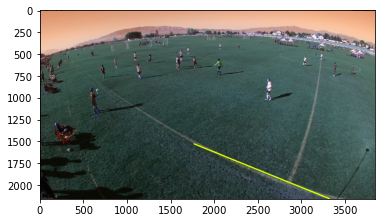

In [94]:
# intersection_global = (intersection[0] + int(im_org.shape[0]/2), intersection[1])
# cv2.circle(im_org, intersection_global, 10, (255, 0 , 0), 40)
plt.imshow(im_org)